# Building Good Training Datasets – Data Preprocessing

### Overview

<br>
<br>

In [3]:
from IPython.display import Image
%matplotlib inline

# Dealing with missing data

## Identifying missing values in tabular data

In [4]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [5]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [6]:
# access the underlying NumPy array
# via the `values` attribute
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

<br>
<br>

## Eliminating training examples or features with missing values

In [7]:
# remove rows that contain missing values

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [9]:
# only drop rows where all columns are NaN

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [10]:
# drop rows that have fewer than 4 real values 

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# only drop rows where NaN appear in specific columns (here: 'C')

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Although the removal of missing data seems to be a convenient approach, it also comes with certain
disadvantages; for example, we may end up removing too many samples, which will make a reliable
analysis impossible. Or, if we remove too many feature columns, we will run the risk of losing valuable
information that our classifier needs to discriminate between classes. In the next section, we will look at
one of the most commonly used alternatives for dealing with missing values: interpolation techniques.

<br>
<br>

## Imputing missing values

In [12]:
# again: our original array
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [13]:
# impute missing values via the column mean

from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

<br>
<br>

In [14]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


# Handling categorical data

## Nominal and ordinal features

In [15]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


<br>
<br>

## Mapping ordinal features

In [16]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [17]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>
<br>

## Encoding class labels

In [18]:
import numpy as np

# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [19]:
# to convert class labels from strings to integers
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [20]:
# reverse the class label mapping
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [21]:
from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [22]:
# reverse mapping
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

<br>
<br>

## Performing one-hot encoding on nominal features

The idea behind
this approach is to create a new dummy feature for each unique value in the nominal feature column.
Here, we would convert the color feature into three new features: blue, green, and red. Binary values
can then be used to indicate the particular color of an example; for example, a blue example can be
encoded as blue=1, green=0, red=0. 

In [23]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

Although the color values don’t
come in any particular order, common classification models, will now assume that green is larger than blue, and red is larger than green. Although this
assumption is incorrect, a classifier could still produce useful results. However, those results would
not be optimal.

In [24]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [25]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [26]:
# one-hot encoding via pandas

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


If features are highly correlated, matrices are computationally difficult to invert, which
can lead to numerically unstable estimates. To reduce the correlation among variables, we can simply
remove one feature column from the one-hot encoded array. Note that we do not lose any important
information by removing a feature column, though; for example, if we remove the column color_blue,
the feature information is still preserved since if we observe color_green=0 and color_red=0, it
implies that the observation must be blue.

In [27]:
# multicollinearity guard in get_dummies

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In [28]:
# multicollinearity guard for the OneHotEncoder

color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

<br>
<br>

## Optional: Encoding Ordinal Features

If we are unsure about the numerical differences between the categories of ordinal features, or the difference between two ordinal values is not defined, we can also encode them using a threshold encoding with 0/1 values. For example, we can split the feature "size" with values M, L, and XL into two new features "x > M" and "x > L". Let's consider the original DataFrame:

In [29]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


We can use the `apply` method of pandas' DataFrames to write custom lambda expressions in order to encode these variables using the value-threshold approach:

In [30]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


<br>
<br>

# Partitioning a dataset into a separate training and test set

In [31]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [32]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

If we are dividing a dataset into training and test datasets, we have to keep in mind that
we are withholding valuable information that the learning algorithm could benefit from.
Thus, we don’t want to allocate too much information to the test set. However, the smaller
the test set, the more inaccurate the estimation of the generalization error. Dividing a
dataset into training and test datasets is all about balancing this tradeoff.

<br>
<br>

# Bringing features onto the same scale

In [33]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [34]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

A visual example:

In [35]:
ex = np.array([0, 1, 2, 3, 4, 5])

# standardize
print('standardized:', (ex - ex.mean()) / ex.std())

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


<br>
<br>

# Selecting meaningful features

...

## L1 and L2 regularization as penalties against model complexity

For regularized models in scikit-learn that support L1 regularization, we can simply set the `penalty` parameter to `'l1'` to obtain a sparse solution:

In [36]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

LogisticRegression(penalty='l1')

Applied to the standardized Wine data ...

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. We can increase
# or decrease it to make the regularization effect
# weaker or stronger, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [38]:
lr.intercept_

array([-1.26312746, -1.21570325, -2.37143497])

Since we fit the LogisticRegression object on a multiclass dataset via the one-versus-rest (OvR)
approach, the first intercept belongs to the model that fits class 1 versus classes 2 and 3, the second
value is the intercept of the model that fits class 2 versus classes 1 and 3, and the third value is the
intercept of the model that fits class 3 versus classes 1 and 2

In [39]:
np.set_printoptions(8)

In [40]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [41]:
lr.coef_

array([[ 1.24566948,  0.18062137,  0.74266191, -1.16042121,  0.        ,
         0.        ,  1.17461542,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54228833,  2.51092444],
       [-1.53852858, -0.38603334, -0.99520652,  0.36365688, -0.05923546,
         0.        ,  0.6670455 ,  0.        ,  0.        , -1.93241279,
         1.23711293,  0.        , -2.23325426],
       [ 0.13557808,  0.16967613,  0.35747613,  0.        ,  0.        ,
         0.        , -2.43490859,  0.        ,  0.        ,  1.56169347,
        -0.81777737, -0.49645541,  0.        ]])

The weight array that we accessed via the lr.coef_ attribute contains three rows of weight coefficients,
one weight vector for each class. Each row consists of 13 weights, where each weight is multiplied by
the respective feature in the 13-dimensional Wine dataset to calculate the net input:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_

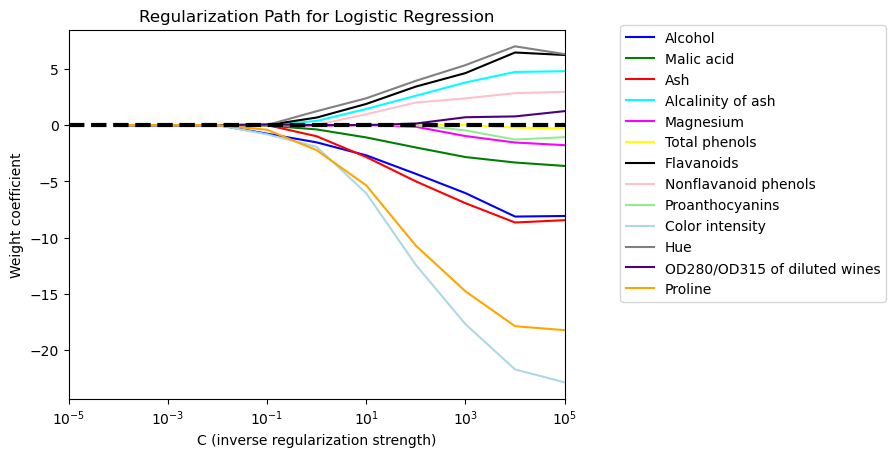

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.title('Regularization Path for Logistic Regression')

plt.show()

The resulting plot provides us with further insights into the behavior of L1 regularization. As we can
see, all feature weights will be zero if we penalize the model with a strong regularization parameter
(C<0.01); C is the inverse of the regularization parameter, 𝜆.

<br>
<br>

## Sequential feature selection algorithms

An alternative way to reduce the complexity of the model and avoid overfitting is dimensionality
reduction via feature selection, which is especially useful for unregularized models. There are two
main categories of dimensionality reduction techniques: feature selection and feature extraction. Via
feature selection, we select a subset of the original features, whereas in feature extraction, we derive
information from the feature set to construct a new feature subspace.

Sequential feature selection algorithms are a family of greedy search algorithms that are used to
reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k<d. The
motivation behind feature selection algorithms is to automatically select a subset of features that are
most relevant to the problem, to improve computational efficiency, or to reduce the generalization
error of the model by removing irrelevant features or noise, which can be useful for algorithms that
don’t support regularization.

A classic sequential feature selection algorithm is sequential backward selection (SBS), which aims to
reduce the dimensionality of the initial feature subspace with a minimum decay in the performance
of the classifier to improve upon computational efficiency. In certain cases, SBS can even improve
the predictive power of the model if a model suffers from overfitting.

### SBS Implementation

In [43]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

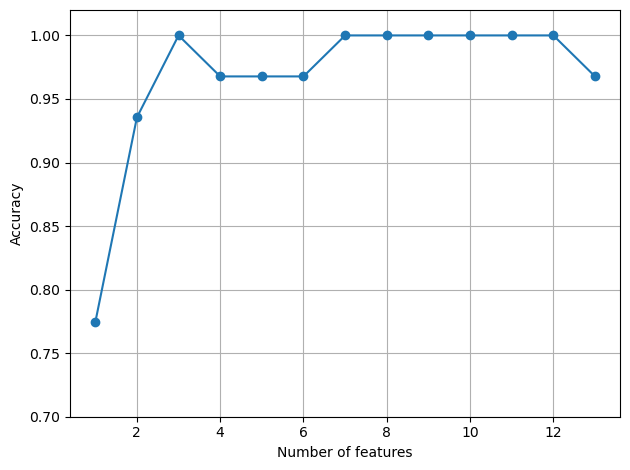

In [44]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [45]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [46]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In the preceding code section, we used the complete feature set and obtained approximately 97 percent
accuracy on the training dataset and approximately 96 percent accuracy on the test dataset, which
indicates that our model already generalizes well to new data. 

In [47]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


When using less than a quarter of the original features in the Wine dataset, the prediction accuracy
on the test dataset declined slightly. This may indicate that those three features do not provide less
discriminatory information than the original dataset.

However, we also have to keep in mind that the
Wine dataset is a small dataset and is very susceptible to randomness—that is, the way we split the
dataset into training and test subsets, and how we split the training dataset further into a training
and validation subset.



While we did not increase the performance of the KNN model by reducing the number of features,
we shrank the size of the dataset, which can be useful in real-world applications that may involve
expensive data collection steps. Also, by substantially reducing the number of features, we obtain
simpler models, which are easier to interpret.

<br>
<br>

# Assessing feature importance with Random Forests

Another useful approach for selecting relevant features from a dataset is using a random forest. Using a random forest, we can measure the feature
importance as the averaged impurity decrease computed from all decision trees in the forest, without
making any assumptions about whether our data is linearly separable or not.

we will now train a forest of 500 trees on the Wine dataset and rank the
13 features by their respective importance measures—remember that
we don’t need to use standardized or normalized features in tree-based models:

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


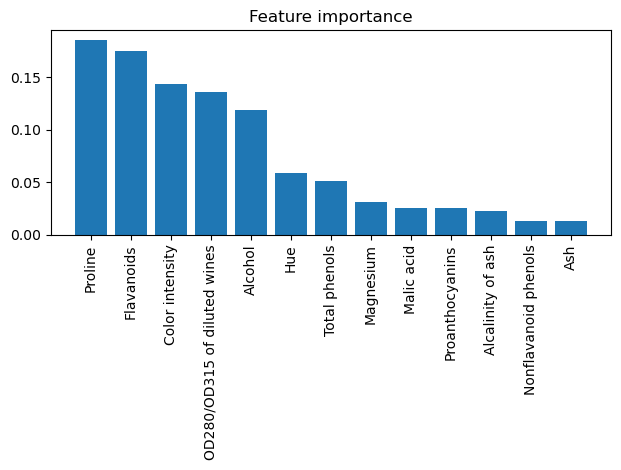

In [48]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Interestingly, two of the top-ranked features
in the plot are also in the three-feature subset selection from the SBS algorithm that we implemented
in the previous section (alcohol concentration and OD280/OD315 of diluted wines).

If two or more features are highly correlated, one feature may
be ranked very highly while the information on the other feature(s) may not be fully captured. On
the other hand, we don’t need to be concerned about this problem if we are merely interested in the
predictive performance of a model rather than the interpretation of feature importance values.

In [49]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Now, let's print the features that met the threshold criterion for feature selection that we set earlier

In [50]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


<br>
<br>